# CNN model

## 1. Import data

In [1]:
import pandas as pd
import sys
import numpy as np

sys.path.append('/kaggle/input/utility-scripts')
from features import add_features

In [2]:
# Import datasets
train_series = pd.read_csv("/kaggle/input/input-data/filtered_train_series_continuous.csv")
test_series = pd.read_csv("/kaggle/input/input-data/filtered_test_series_continuous.csv")

In [3]:
# Add features
train_series = add_features(train_series)
test_series = add_features(test_series)

In [4]:
print(train_series.shape)
print(test_series.shape)

(787158, 40)
(204125, 40)


In [5]:
# Delete NAs
train_series = train_series.dropna()
test_series = test_series.dropna()
print(train_series.shape)
print(test_series.shape)

(786942, 40)
(204072, 40)


### Reshape the training data into 3D with SMOTE

So that it includes time windows (50 = ~7h)

In [6]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [7]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

def convert_to_3d(df, timestep_length=50, resample=True):
    # Ensure the DataFrame is sorted by series_id and step
    df = df.sort_values(by=["series_id", "step"])
        
    # Extract the events
    events = df["event"]
    # Remove the 'series_id' and 'events' column from the features
    features = df.drop(columns=["series_id", "event"])
    
    # SMOTE 
    smote = SMOTE(random_state=42)
    smote_series, smote_event = smote.fit_resample(features, events)
    
    if resample:
        # Split into train and eval
        X_train, X_val, Y_train, Y_val = train_test_split(smote_series, smote_event,
                                                         test_size=0.2, stratify=smote_event,
                                                         random_state=42)
        # Get the number of rows 
        num_rows_train = len(Y_train)
        num_rows_val = len(Y_val)
        # Truncate to the largest multiple of timestep_length
        num_rows_to_keep_train = num_rows_train - (num_rows_train % timestep_length)
        num_rows_to_keep_val = num_rows_val - (num_rows_val % timestep_length)

        # Reshape the events array
        reshaped_event_train = Y_train[:num_rows_to_keep_train].values.reshape(-1, timestep_length)
        reshaped_event_val = Y_val[:num_rows_to_keep_val].values.reshape(-1, timestep_length)
        # Reshape the dataframe into a 3D numpy array: (n_series, timesteps, features)
        reshaped_data_train = X_train[:num_rows_to_keep_train].values.reshape(-1, timestep_length, X_train.shape[1])
        reshaped_data_val = X_val[:num_rows_to_keep_val].values.reshape(-1, timestep_length, X_val.shape[1])
        return reshaped_data_train, reshaped_data_val, reshaped_event_train, reshaped_event_val
    
    # Get the number of rows in the SMOTE resampled events
    num_rows = len(smote_event)
    # Truncate to the largest multiple of timestep_length
    num_rows_to_keep = num_rows - (num_rows % timestep_length)
    
    # Reshape the events array
    reshaped_event = smote_event[:num_rows_to_keep].values.reshape(-1, timestep_length)
    # Reshape the dataframe into a 3D numpy array: (n_series, timesteps, features)
    reshaped_data = smote_series[:num_rows_to_keep].values.reshape(-1, timestep_length, smote_series.shape[1])
    
    return reshaped_data, reshaped_event

In [8]:
shaped_train_data, shaped_val_data, shaped_train_tar, shaped_val_tar = convert_to_3d(train_series)
shaped_test_data, shaped_test_tar = convert_to_3d(test_series, resample=False)

In [9]:
print("Train data:")
print(shaped_train_data.shape)
print(shaped_train_tar.shape, "\n")
print("Eval data:")
print(shaped_val_data.shape)
print(shaped_val_tar.shape, "\n")
print("Test data:")
print(shaped_test_data.shape)
print(shaped_test_tar.shape)

Train data:
(37423, 50, 38)
(37423, 50) 

Eval data:
(9355, 50, 38)
(9355, 50) 

Test data:
(12121, 50, 38)
(12121, 50)


In [10]:
# Calculate class weights
unique, counts = np.unique(shaped_train_tar, return_counts=True)
weights = counts.sum()/counts
print(weights)

[3.00001283 2.99998397 3.00000321]


### One hot encoding

In [11]:
import keras

In [12]:
shaped_train_target = keras.utils.to_categorical(shaped_train_tar)
shaped_val_target = keras.utils.to_categorical(shaped_val_tar)
shaped_test_target = keras.utils.to_categorical(shaped_test_tar)

In [13]:
print("One hot encoded targets:")
print(shaped_train_target.shape)
print(shaped_val_target.shape)
print(shaped_test_target.shape)

One hot encoded targets:
(37423, 50, 3)
(9355, 50, 3)
(12121, 50, 3)


## 2. Build and run model

### Home-made loss function

In [14]:
# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Conv1D, MaxPooling1D, BatchNormalization, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve


In [15]:
def weighted_categorical_crossentropy(weights):
    
    weights = K.variable(weights)

    def loss(y_true, y_pred):
        """Calculate weighted categorical crossentropy loss."""
        # Clip predictions to avoid log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        # Calculate unweighted categorical crossentropy
        cce = y_true * K.log(y_pred)
        
        # Multiply with weights for each class
        weighted_cce = cce * weights
        
        # Take mean across timesteps and batch dimensions
        return -K.mean(K.sum(weighted_cce, axis=-1))  # sum across classes, mean across batch and timesteps

    return loss

### Build and train the model

In [16]:
def find_optimal_threshold(test_target_classes, test_pred, num_classes=3):
    thresholds = np.arange(0.1, 0.9, 0.01)  # Range of thresholds to search
    best_thresholds = []
    best_f1_scores = []
    
    # Loop through each class to find the best threshold for maximizing F1 score
    for i in range(num_classes):
        f1_scores = []
        for threshold in thresholds:
            # Binarize predictions using the threshold
            binary_pred = (test_pred[:, i] >= threshold).astype(int)
            binary_true = (test_target_classes == i).astype(int)

            # Compute F1 score
            f1 = f1_score(binary_true, binary_pred, zero_division=1)
            f1_scores.append(f1)

        # Get the best threshold for this class
        best_idx = np.argmax(f1_scores)
        best_thresholds.append(thresholds[best_idx])
        best_f1_scores.append(f1_scores[best_idx])

        print(f"Class {i} - Best Threshold: {best_thresholds[-1]}, Best F1 Score: {best_f1_scores[-1]}")
    
    return best_thresholds, best_f1_scores

In [17]:
def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding="same"))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))

    # Ajouter des couches denses
    model.add(Dense(32, activation='relu'))
    
    model.add(Dense(3, activation='softmax'))
    
    model.summary()
    return model


def train_cnn_model(X_train, Y_train,
                    X_val, Y_val,
                    class_weights):
    
    # Ensure data is in the correct numerical format
    X_train = np.array(X_train, dtype=np.float32)
    Y_train = np.array(Y_train, dtype=np.int32)
    X_val = np.array(X_val, dtype=np.float32)
    Y_val = np.array(Y_val, dtype=np.int32)

    # Define the input shape for the model
    input_shape = X_train.shape[1:]
    
    # Build and compile the model
    model = build_cnn_model(input_shape)
    model.compile(loss=weighted_categorical_crossentropy(class_weights), 
                  optimizer='adam', metrics=['accuracy', 'precision'])

    # Define early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(x=X_train, y=Y_train, batch_size=64,
                        validation_data=(X_val, Y_val),
                        epochs=20, callbacks=[early_stop])

    # Evaluate the model on the validation set
    test_pred = model.predict(X_val).reshape(-1, 3)
    test_target_classes = np.argmax(Y_val.reshape(-1, 3), axis=1)

    # Find optimal thresholds for each class
    best_thresholds, _ = find_optimal_threshold(test_target_classes, test_pred)

    # Apply the optimal thresholds to get final predictions
    final_pred_classes = []
    for i in range(len(best_thresholds)):
        # Binarize predictions using the optimal thresholds
        binary_pred = (test_pred[:, i] >= best_thresholds[i]).astype(int)
        final_pred_classes.append(binary_pred)

    # Combine final predictions for each class
    final_pred_classes = np.array(final_pred_classes).T  # Shape: (num_samples, num_classes)
    
    # Get the predicted class based on the maximum value across the classes
    final_pred_classes = np.argmax(final_pred_classes, axis=1)

    # Calculate precision, accuracy, recall, and F1-score
    precision = precision_score(test_target_classes, final_pred_classes, average='macro')
    accuracy = accuracy_score(test_target_classes, final_pred_classes)
    recall = recall_score(test_target_classes, final_pred_classes, average='macro')
    f1 = f1_score(test_target_classes, final_pred_classes, average='macro')

    # Save the metrics for this fold
    metrics = {
        'precision': precision,
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1
    }
    
    return model, metrics

In [18]:
model, metrics = train_cnn_model(shaped_train_data, shaped_train_target,
                                 shaped_val_data, shaped_val_target,
                                 weights)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 50, 64)         │         7,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50, 3)          │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,827 (69.64 KB)

 Trainable params: 17,827 (69.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1729734870.934197      69 service.cc:145] XLA service 0x795980004ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729734870.934257      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 59/585 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3377 - loss: 32.0242 - precision: 0.3377

I0000 00:00:1729734876.244893      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


585/585 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.3368 - loss: 32.0697 - precision: 0.3368 - val_accuracy: 0.3401 - val_loss: 31.9112 - val_precision: 0.3401
Epoch 2/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3347 - loss: 32.1691 - precision: 0.3347 - val_accuracy: 0.3401 - val_loss: 31.9112 - val_precision: 0.3401
Epoch 3/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3348 - loss: 32.1638 - precision: 0.3348 - val_accuracy: 0.3333 - val_loss: 32.2362 - val_precision: 0.3333
Epoch 4/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3332 - loss: 32.2441 - precision: 0.3332 - val_accuracy: 0.3333 - val_loss: 32.2362 - val_precision: 0.3333
Epoch 5/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3335 - loss: 32.2281 - precision: 0.3335 - val_accuracy: 0.3333 - val_loss: 32.2362 - val_precision: 0.3333
Epoch 6/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3330 - loss: 32.2538 - precision: 0.3330 - val_accuracy: 0.3333 - val_los

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
model.save("model_CNN.keras")

### Plot the results

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

#### Confusion matrix

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics

def plot_confusion_matrix(model, x_test, y_test):
    # Generate predictions
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=-1)
    y_test_classes = np.argmax(y_test, axis=-1)

    # Flatten the predictions and true labels
    y_pred_classes_flat = y_pred_classes.flatten()
    y_test_classes_flat = y_test_classes.flatten()

    # Compute the confusion matrix
    confusion_mtx = sklearn.metrics.confusion_matrix(y_test_classes_flat, y_pred_classes_flat, normalize="true")

    # Set up the matplotlib figure
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    # Create the heatmap
    heatmap = sns.heatmap(confusion_mtx, annot=True, fmt=".2f", cmap="Blues", square=True)

    # Customize the axes and titles
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Show the plot
    plt.tight_layout()
    plt.show()


379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


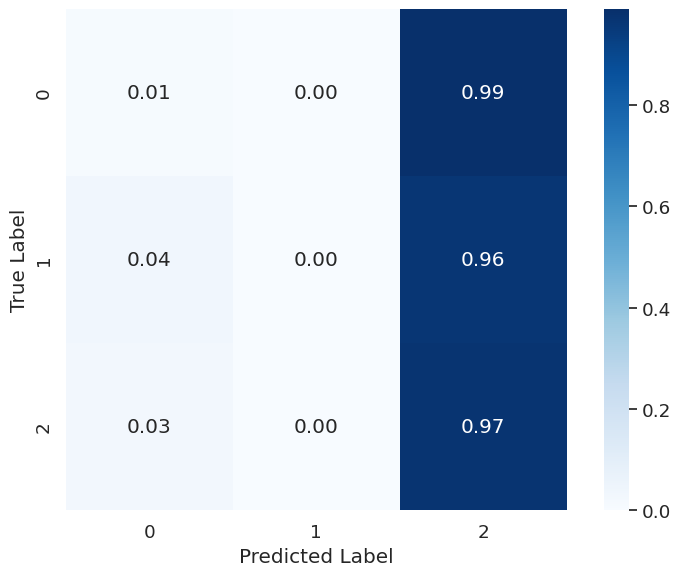

In [22]:
plot_confusion_matrix(model, shaped_test_data, shaped_test_target)

### K-fold validation

In [23]:
def train_cnn_model_with_kfold(series, target, class_weights, k=3):
    
    # Ensure data is in the correct numerical format
    series = np.array(series, dtype=np.float32)
    target = np.array(target, dtype=np.int32)

    # Initialize the KFold cross-validator
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    histories = []
    fold_metrics = []

    # Perform K-Fold cross-validation
    for fold, (train_idx, test_idx) in enumerate(kf.split(series)):
        print(f"\nTraining fold {fold + 1}/{k}...")

        # Split the data into train and validation sets
        train_series, test_series = series[train_idx], series[test_idx]
        train_target, test_target = target[train_idx], target[test_idx]

        # Train the CNN model
        model, metrics = train_cnn_model(train_series, train_target, test_series, test_target, class_weights)

        # Save the history and model for this fold
        histories.append(model.history)

        # Save metrics for this fold
        fold_metrics.append(metrics)

    return histories, fold_metrics

In [24]:
histories, fold_metrics = train_cnn_model_with_kfold(shaped_train_data, shaped_train_target, weights)


Training fold 1/3...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 50, 64)         │         7,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 50, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50, 3)          │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,827 (69.64 KB)

 Trainable params: 17,827 (69.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.3332 - loss: 32.2431 - precision: 0.3332 - val_accuracy: 0.3346 - val_loss: 32.1755 - val_precision: 0.3346
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3330 - loss: 32.2512 - precision: 0.3330 - val_accuracy: 0.3303 - val_loss: 32.3806 - val_precision: 0.3303
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3301 - loss: 32.3914 - precision: 0.3301 - val_accuracy: 0.3331 - val_loss: 32.2483 - val_precision: 0.3331
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3328 - loss: 32.2600 - precision: 0.3328 - val_accuracy: 0.3331 - val_loss: 32.2483 - val_precision: 0.3331
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3322 - loss: 32.2898 - precision: 0.3322 - val_accuracy: 0.3331 - val_loss: 32.2483 - val_precision: 0.3331
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3332 - loss: 32.2403 - precision: 0.3332 - val_accuracy: 0.333

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 50, 64)         │         7,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 50, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50, 3)          │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,827 (69.64 KB)

 Trainable params: 17,827 (69.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.3395 - loss: 31.9352 - precision: 0.3395 - val_accuracy: 0.3331 - val_loss: 32.2453 - val_precision: 0.3331
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3345 - loss: 32.1792 - precision: 0.3345 - val_accuracy: 0.3331 - val_loss: 32.2453 - val_precision: 0.3331
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3347 - loss: 32.1679 - precision: 0.3347 - val_accuracy: 0.3346 - val_loss: 32.1750 - val_precision: 0.3346
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3361 - loss: 32.1010 - precision: 0.3361 - val_accuracy: 0.3331 - val_loss: 32.2453 - val_precision: 0.3331
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3336 - loss: 32.2211 - precision: 0.3336 - val_accuracy: 0.3331 - val_loss: 32.2453 - val_precision: 0.3331
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3333 - loss: 32.2394 - precision: 0.3333 - val_accuracy: 0.333

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 50, 64)         │         7,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 50, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 50, 3)          │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,827 (69.64 KB)

 Trainable params: 17,827 (69.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3338 - loss: 32.2139 - precision: 0.3338 - val_accuracy: 0.3337 - val_loss: 32.2174 - val_precision: 0.3337
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3336 - loss: 32.2249 - precision: 0.3336 - val_accuracy: 0.3337 - val_loss: 32.2174 - val_precision: 0.3337
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3331 - loss: 32.2470 - precision: 0.3331 - val_accuracy: 0.3337 - val_loss: 32.2174 - val_precision: 0.3337
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3331 - loss: 32.2464 - precision: 0.3331 - val_accuracy: 0.3337 - val_loss: 32.2174 - val_precision: 0.3337
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3329 - loss: 32.2559 - precision: 0.3329 - val_accuracy: 0.3337 - val_loss: 32.2174 - val_precision: 0.3337
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3329 - loss: 32.2581 - precision: 0.3329 - val_accuracy: 0.333

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Metrics

In [25]:
def print_fold_metrics_summary(fold_metrics):
    # Convert fold_metrics (list of dicts) into a DataFrame
    metrics_df = pd.DataFrame(fold_metrics)
    
    # Calculate mean and standard error for each metric
    summary_df = pd.DataFrame({
        'Metric': ['accuracy', 'precision', 'recall', 'f1_score'],
        'Mean': [
            metrics_df['accuracy'].mean(),
            metrics_df['precision'].mean(),
            metrics_df['recall'].mean(),
            metrics_df['f1_score'].mean()
        ],
        'Standard Error': [
            metrics_df['accuracy'].std() / np.sqrt(len(metrics_df)),
            metrics_df['precision'].std() / np.sqrt(len(metrics_df)),
            metrics_df['recall'].std() / np.sqrt(len(metrics_df)),
            metrics_df['f1_score'].std() / np.sqrt(len(metrics_df))
        ]
    })

    # Print the summary table
    print(summary_df.to_string(index=False))


def print_overall_metrics(metrics):
    # Specify the desired order of metrics
    metric_order = ['accuracy', 'precision', 'recall', 'f1_score']
    # Create a DataFrame from the metrics dictionary
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
    # Reindex the DataFrame to ensure the desired order
    metrics_df = metrics_df.reindex(metric_order)
    # Print the metrics table
    print(metrics_df.to_string(index=True, header=False))

In [26]:
print_fold_metrics_summary(fold_metrics)

   Metric     Mean  Standard Error
 accuracy 0.334301        0.000290
precision 0.303660        0.048646
   recall 0.334319        0.000559
 f1_score 0.203451        0.033595


In [27]:
print_overall_metrics(metrics)

accuracy   0.340053
precision  0.244355
recall     0.340055
f1_score   0.198787
